In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

file_name = 'Multimedia_dataset.zip'
zip_path = '/content/drive/MyDrive/Multimedia&Lab/Multimedia_dataset.zip'

!cp "{zip_path}" .
!unzip -q '{file_name}'
!rm '{file_name}'

In [3]:
file_name = 'noise_test_dataset.zip'
zip_path = '/content/drive/MyDrive/Multimedia&Lab/noise_test_dataset.zip'

!cp "{zip_path}" .
!unzip -q '{file_name}'
!rm '{file_name}'

# Import Libraries

In [4]:
%matplotlib notebook
%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

print('Device id: ', torch.cuda.current_device())
print('Available: ', torch.cuda.is_available())
print('Property: ', torch.cuda.get_device_properties(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Device id:  0
Available:  True
Property:  _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [5]:
dataset_root_dir = '/content/'
test_dataset_root_dir = '/content/'

- Augmentation

참고: https://hoya012.github.io/blog/albumentation_tutorial/


Albumentations: Fast and Flexible Image Augmentations 라는 이름으로 
2020년 Information 저널에 출판이 되었으며 현재 6명의 연구자들이 관리 중이며 계속해서 새로운 기능들이 추가되고 있다.


list 안의 있는 transform 들 중 하나를 random하게 가져온다. 
또한 OneOf 함수 자체에도 확률을 부여할 수 있다. 
만약 one of([…], p=0.5) 였다면, 0.5확률로는 해당 transform을 스킵하고, 
아래와 같이 3개의 transform을 list로 받았다면 각 transform들은 1/6 확률로 선택이 된다.

Horizontal Flip, Rotation, Vertical Flip 중에 하나를 random하게 선택하고, 
Blur, Distortion, Noise 연산 중 하나를 random하게 선택한다. 
즉 3x3 = 9가지의 조합이 가능하다.
'''

# Define Dataloader

In [6]:
class NoisyBSDSDataset(td.Dataset):
  def __init__(self, root_dir, mode='train', image_size=(128,128), sigma=30):
    super(NoisyBSDSDataset, self).__init__()
    self.mode = mode
    self.image_size = image_size
    self.sigma = sigma
    self.images_dir = os.path.join(root_dir, mode)
    self.files = os.listdir(self.images_dir)

  def __len__(self):
    return len(self.files)
  
  def __repr__(self):
    return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})".\
    format(self.mode, self.image_size, self.sigma)

  def __getitem__(self, idx):
    img_path = os.path.join(self.images_dir, self.files[idx])
    clean = Image.open(img_path).convert('RGB')
    i = np.random.randint(abs(clean.size[0] - self.image_size[0]))
    j = np.random.randint(abs(clean.size[1] - self.image_size[1]))

    clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
    transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                       tv.transforms.Normalize((0.5,0.5,0.5),
                                                               (0.5,0.5,0.5), inplace=True)
                                       ])
    clean = transform(clean)
    noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)

    return noisy,clean

train_set = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(128,128))
val_set = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='validation', image_size=(128,128))
test_set = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(128,128))

In [7]:
print(len(test_set))

train_examples = os.listdir(dataset_root_dir+"train")
#val_examples = os.listdir(val_root)
test_examples = os.listdir(test_dataset_root_dir+"test")

#image read
train_img = plt.imread(dataset_root_dir + "train/" + train_examples[1])
print(train_img.shape)
test_img = plt.imread(test_dataset_root_dir + "test/" + test_examples[1])
print(test_img.shape)

1000
(256, 256, 3)
(128, 128, 3)


# Plotting and Image functions

In [8]:
def myimshow(image, ax=plt):
  image = image.to('cpu').numpy()
  image = np.moveaxis(image, [0,1,2], [2,0,1])
  image = (image + 1) / 2
  image[image < 0] = 0
  image[image > 1] = 1
  
  h = ax.imshow(image)
  ax.axis('off')

  return h

In [9]:
def plot(exp, fig, axes, noisy, visu_rate=2):
  if exp.epoch % visu_rate != 0:
    return
  with torch.no_grad():
    denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
  
  axes[0][0].clear()
  axes[0][1].clear()
  axes[1][0].clear()
  axes[1][1].clear()
  axes[1][2].clear()

  myimshow(noisy, ax=axes[0][0])
  axes[0][0].set_title('Noisy image')
  myimshow(denoised, ax=axes[0][1])
  axes[0][1].set_title('Denoised image')

  axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
  axes[1][0].set_title('Training loss')
  axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="psnr")
  axes[1][1].set_title('psnr')
  axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="ssim")
  axes[1][2].set_title('ssim')

  plt.tight_layout()
  fig.canvas.draw()

In [10]:
def showImage(idx):
  noisy,clean = test_set[idx]
  with torch.no_grad():
    denoised = exp1.net(noisy[np.newaxis].to(exp1.net.device))[0]

  fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,8), sharex='all', sharey='all')
  axes[0][0].set_title("Noisy")
  myimshow(noisy, axes[0][0])
  axes[1][0].set_title("Denoised")
  myimshow(denoised, axes[1][0])
  axes[0][1].set_title("Clean")
  myimshow(clean, axes[0][1])

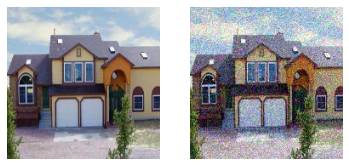

In [11]:
x = train_set[14]
fig, (ax1, ax2) = plt.subplots(ncols=2)
myimshow(x[1], ax=ax1)
myimshow(x[0], ax=ax2)

# DnCNN

Model

In [12]:
class NNRegressor(nt.NeuralNetwork):
  def __init__(self):
    super(NNRegressor, self).__init__()
    self.loss = nn.MSELoss()

  def criterion(self, y, d):
    return self.loss(y,d)

In [14]:
class DnCNN(NNRegressor):
  def __init__(self, D, C=64):
    super(DnCNN, self).__init__()
    self.D = D
    self.conv = nn.ModuleList()
    self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))

    for i in range(D):
      self.conv.append(nn.Conv2d(C, C, 3, padding=(1,1)))
    self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))

    self.bn = nn.ModuleList()
    for k in range(D):
      self.bn.append(nn.BatchNorm2d(C))
  
  def forward(self, x):
    D = self.D
    h = F.relu(self.conv[0](x))

    for i in range(1, D+1):
      h = F.relu(self.bn[i-1](self.conv[i](h)))
    y = self.conv[D+1](h) + x

    return y

Stat manager

In [13]:
import pytorch_ssim

class DenoisingStatsManager(nt.StatsManager):

  def __init__(self):
    super(DenoisingStatsManager, self).__init__()

  def init(self):
    super(DenoisingStatsManager, self).init()
    self.running_psnr = 0
    self.count = 0
    self.ssim_value = 0
    self.ssim_loss = 0

  def accumulate(self, loss, x, y, d):
    super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
    mse = torch.sum((y-d)**2).float()
    self.running_psnr += 10 * torch.log10((4*y.numel())/mse)
    self.count += 1
    self.ssim_value += pytorch_ssim.ssim(y, d)
    loss = pytorch_ssim.SSIM(window_size = 11)
    self.ssim_loss += loss(y,d)

  def summarize(self):
    loss = super(DenoisingStatsManager, self).summarize()
    psnr = self.running_psnr / self.count
    ssim = self.ssim_value / self.count
    return {'loss':loss, 'psnr':psnr, 'ssim':ssim}

Experiment 1

In [ ]:
lr = 1e-3
net = DnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()

exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager, batch_size=4,
                      output_dir="denoising_output_exp1", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 87.40s | Training Loss: 0.012428 | Evaluation Loss: 0.008022
Epoch 2 | Time: 88.70s | Training Loss: 0.007549 | Evaluation Loss: 0.007096
Epoch 3 | Time: 89.66s | Training Loss: 0.006868 | Evaluation Loss: 0.006848
Epoch 4 | Time: 89.66s | Training Loss: 0.006540 | Evaluation Loss: 0.006534
Epoch 5 | Time: 89.78s | Training Loss: 0.006376 | Evaluation Loss: 0.006355
Epoch 6 | Time: 89.85s | Training Loss: 0.006164 | Evaluation Loss: 0.006177
Epoch 7 | Time: 89.79s | Training Loss: 0.006049 | Evaluation Loss: 0.006140
Epoch 8 | Time: 89.74s | Training Loss: 0.005994 | Evaluation Loss: 0.005997
Epoch 9 | Time: 89.81s | Training Loss: 0.005858 | Evaluation Loss: 0.005976
Epoch 10 | Time: 89.84s | Training Loss: 0.005794 | Evaluation Loss: 0.005803
Epoch 11 | Time: 90.26s | Training Loss: 0.005732 | Evaluation Loss: 0.005903
Epoch 12 | Time: 89.96s | Training Loss: 0.005694 | Evaluation Loss: 0.005915
Epoch 13 | Time: 89.82s | Training L

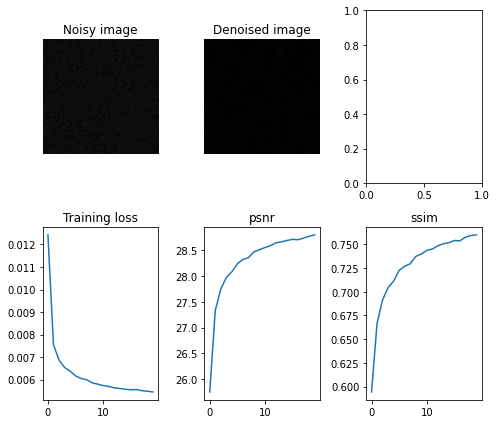

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

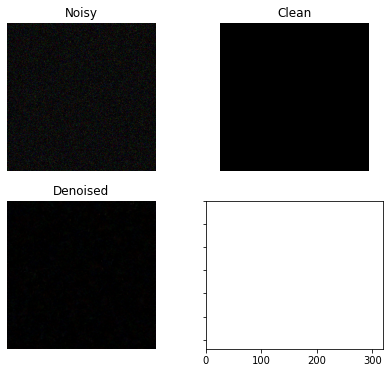

In [ ]:
showImage(15)

# U-net like CNNs

Model

In [ ]:
class UDnCNN(NNRegressor):
  def __init__(self, D, C=64):
    super(UDnCNN, self).__init__()
    self.D = D
    self.conv = nn.ModuleList()
    self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))

    for i in range(D):
      self.conv.append(nn.Conv2d(C, C, 3, padding=(1,1)))
    self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))

    self.bn = nn.ModuleList()
    for k in range(D):
      self.bn.append(nn.BatchNorm2d(C))

    self.pool_indices = []
    for i in range(D):
      if i < D/2-1:
        self.pool_indices.append(i)
      elif i > D/2:
        self.pool_indices.append(i)
  
  def forward(self, x):
    sizes = []
    indices = []
    features = []

    D = self.D
    h = F.relu(self.conv[0](x))
    features.append(h)

    for i in range(D):
      if i in self.pool_indices and i < D/2-1:
        sizes.append(h.size())
        h,idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), kernel_size=2, return_indices=True)
        
        features.append(h)
        indices.append(idx)
      
      elif i in self.pool_indices and i > D/2:
        last_size = sizes.pop()
        last_feature = features.pop()

        h += last_feature
        h /= 2**0.5

        idx = indices.pop()

        h = F.max_unpool2d(F.relu(self.bn[i](self.conv[i+1](h))), output_size=last_size, kernel_size=2, indices=idx)
      
      else:
        h = F.relu(self.bn[i](self.conv[i+1](h)))
    
    last_feature = features.pop()
    h += last_feature
    h /= 2**0.5

    y = self.conv[D+1](h) + x

    return y

Experiment 2

In [ ]:
lr = 1e-3
net = UDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,
                      output_dir="denoising_output_exp2", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 58.79s | Training Loss: 0.011357 | Evaluation Loss: 0.003310
Epoch 2 | Time: 59.04s | Training Loss: 0.007297 | Evaluation Loss: 0.002112
Epoch 3 | Time: 59.14s | Training Loss: 0.006749 | Evaluation Loss: 0.002085
Epoch 4 | Time: 59.20s | Training Loss: 0.006484 | Evaluation Loss: 0.001924
Epoch 5 | Time: 58.98s | Training Loss: 0.006331 | Evaluation Loss: 0.003282
Epoch 6 | Time: 59.01s | Training Loss: 0.006156 | Evaluation Loss: 0.001950
Epoch 7 | Time: 58.92s | Training Loss: 0.006052 | Evaluation Loss: 0.001518
Epoch 8 | Time: 58.80s | Training Loss: 0.005970 | Evaluation Loss: 0.001444
Epoch 9 | Time: 58.91s | Training Loss: 0.005930 | Evaluation Loss: 0.002351
Epoch 10 | Time: 58.76s | Training Loss: 0.005882 | Evaluation Loss: 0.001563
Epoch 11 | Time: 58.89s | Training Loss: 0.005868 | Evaluation Loss: 0.001849
Epoch 12 | Time: 58.90s | Training Loss: 0.005817 | Evaluation Loss: 0.002077
Epoch 13 | Time: 58.95s | Training L

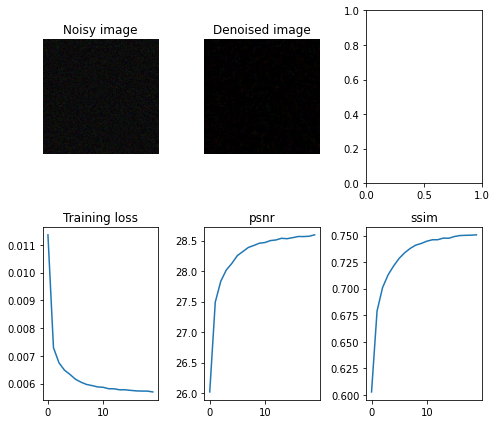

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

# Comparison between CNN and U-Net

In [ ]:
eval1 = exp1.evaluate()
eval2 = exp2.evaluate()

print("loss of DnCNN: {} \t\t\t loss of UDnCNN: {}\n".format(eval1["loss"],eval2["loss"]))
print("PSNR of DnCNN: {} \t\t\t PSNR of UDnCNN: {}\n".format(eval1["psnr"].cpu().numpy(), 
                                                             eval2["psnr"].cpu().numpy()))
print("SSIM of DnCNN: {} \t\t\t SSIM of UDnCNN: {}\n".format(eval1["ssim"],eval2["ssim"]))

loss of DnCNN: 0.005615252688527107 			 loss of UDnCNN: 0.0018755898792296648

PSNR of DnCNN: 28.647809982299805 			 PSNR of UDnCNN: 33.42688751220703

SSIM of DnCNN: 0.7649499773979187 			 SSIM of UDnCNN: 0.6605926156044006



# U-Net like CNNs with dilated convloutions

Model

In [15]:
class DUDnCNN(NNRegressor):
  def __init__(self, D, C=64):
    super(DUDnCNN, self).__init__()
    self.D = D
    self.conv = nn.ModuleList()
    self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))

    dilation = 1
    for i in range(D):
      if i < D/2 and i!=0:
        dilation *= 2
      if i > D/2:
        dilation //= 2
      
      self.conv.append(nn.Conv2d(C, C, 3, padding=(dilation, dilation), dilation=(dilation,dilation)))
    
    self.conv.append(nn.Conv2d(C, 3, 3, padding=(1,1)))
    
    self.bn = nn.ModuleList()
    for i in range(D):
      self.bn.append(nn.BatchNorm2d(C))
  
  def forward(self, x):
    
    sizes = []
    indices = []
    features = []

    D = self.D
    h = F.relu(self.conv[0](x))
    features.append(h)

    for i in range(D):
      if i < D/2-1:
        sizes.append(h.size())
        torch.backends.cudnn.benchmark=True
        h = self.conv[i+1](h)
        torch.backends.cudnn.benchmark=False
        h = F.relu(self.bn[i](h))
    
        features.append(h)
      
      elif i > D/2:
        last_size = sizes.pop()
        last_feature = features.pop()

        h += last_feature
        h /= 2**0.5

        torch.backends.cudnn.benchmark=True
        h = self.conv[i+1](h)
        torch.backends.cudnn.benchmark=False
        h = F.relu(self.bn[i](h))
      
      else:
        torch.backends.cudnn.benchmark=True
        h = self.conv[i+1](h)
        torch.backends.cudnn.benchmark=False
        h = F.relu(self.bn[i](h))
    
    last_feature = features.pop()
    h += last_feature
    h /= 2**0.5

    y = self.conv[D+1](h) + x

    return y

Experiment 3

In [16]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 117.94s | Training Loss: 0.010116 | Evaluation Loss: 0.002044
Epoch 2 | Time: 120.39s | Training Loss: 0.006906 | Evaluation Loss: 0.001738
Epoch 3 | Time: 120.34s | Training Loss: 0.006344 | Evaluation Loss: 0.001536
Epoch 4 | Time: 120.60s | Training Loss: 0.006018 | Evaluation Loss: 0.001136
Epoch 5 | Time: 120.82s | Training Loss: 0.005839 | Evaluation Loss: 0.001112
Epoch 6 | Time: 121.04s | Training Loss: 0.005673 | Evaluation Loss: 0.000996
Epoch 7 | Time: 121.37s | Training Loss: 0.005585 | Evaluation Loss: 0.001038
Epoch 8 | Time: 120.87s | Training Loss: 0.005493 | Evaluation Loss: 0.001071
Epoch 9 | Time: 120.39s | Training Loss: 0.005429 | Evaluation Loss: 0.000746
Epoch 10 | Time: 120.64s | Training Loss: 0.005419 | Evaluation Loss: 0.000989
Epoch 11 | Time: 120.52s | Training Loss: 0.005336 | Evaluation Loss: 0.000794
Epoch 12 | Time: 120.78s | Training Loss: 0.005304 | Evaluation Loss: 0.002832
Epoch 13 | Time: 120.79s

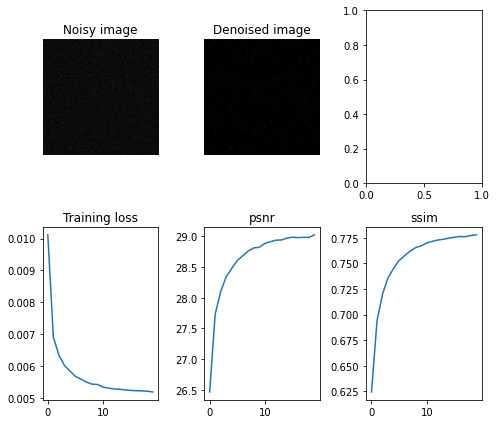

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

# Comparison between UDnCNN and DUDnCNN 

In [ ]:
eval2 = exp2.evaluate()
eval3 = exp3.evaluate()

print("loss of UDnCNN: {} \t\t\t loss of DUDnCNN: {}\n".format(eval2["loss"],eval3["loss"]))
print("PSNR of UDnCNN: {} \t\t\t PSNR of DUDnCNN: {}\n".format(eval2["psnr"].cpu().numpy(), 
                                                             eval3["psnr"].cpu().numpy()))
print("SSIM of UDnCNN: {} \t\t\t SSIM of DUDnCNN: {}\n".format(eval2["ssim"],eval3["ssim"]))

loss of UDnCNN: 0.0018700289051048458 			 loss of DUDnCNN: 0.000760234322049655

PSNR of UDnCNN: 33.437171936035156 			 PSNR of DUDnCNN: 38.07072067260742

SSIM of UDnCNN: 0.6607125997543335 			 SSIM of DUDnCNN: 0.9277169704437256



# To make new model

In [ ]:
class DUDnCNN_myself(NNRegressor):
  def __init__(self, D, C=64):
    super(DUDnCNN_myself, self).__init__()
    self.D = D
    self.conv = nn.ModuleList()
    self.conv.append(nn.Conv2d(3, C, 3, padding=(1,1)))

    # compute k(max_pool) and l(max_unpool)
    k = [0]
    k.extend([i for i in range(D//2)])
    k.extend([k[-1] for _ in range(D//2, D+1)])
    l = [0 for _ in range(D//2+1)]
    l.extend([i for i in range(D+1-(D//2+1))])
    l.append(l[-1])

    #holes and dilations for convolution layers
    holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
    dilations = [i+1 for i in holes]

    #convolution layers
    self.conv = nn.ModuleList()
    self.conv.append(nn.Conv2d(3,C,3, 
                               padding=dilations[0], 
                               dilation=dilations[0]))
    self.conv.extend([nn.Conv2d(C,C,3,
                                padding=dilations[i+1],
                                dilation=dilations[i+1]) for i in range(D)])
    self.conv.append(nn.Conv2d(C,3,3,
                               padding=dilations[-1],
                               dilation=dilations[-1]))
    for i in range(len(self.conv[:-1])):
      nn.init.kaiming_normal_(self.conv[i].weight.data, nonlinearity='relu')
    
    #batch normalization
    self.bn = nn.ModuleList()
    self.bn.extend([nn.BatchNorm2d(C,C) for _ in range(D)])
    for i in range(D):
      nn.init.constant_(self.bn[i].weight.data, 1.25*np.sqrt(C))

  def forward(self, x):
    
    D = self.D
    h = F.relu(self.conv[0](x))
    h_buff = []

    for i in range(D//2 - 1):
      torch.backends.cudnn.benchmark = True
      h = self.conv[i+1](h)
      torch.backends.cudnn.benchmark = False
      h = F.relu(self.bn[i](h))
      h_buff.append(h)

    for i in range(D//2 - 1, D//2 + 1):
      torch.backends.cudnn.benchmark = True
      h = self.conv[i+1](h)
      torch.backends.cudnn.benchmark = False
      h = F.relu(self.bn[i](h))

    for i in range(D//2+1, D):
      j = i - (D//2+1) +1
      torch.backends.cudnn.benchmark = True
      h = self.conv[i+1]((h+h_buff[-j])/np.sqrt(2))
      torch.backends.cudnn.benchmark = False
      h = F.relu(self.bn[i](h))

    y = self.conv[D+1](h) + x

    return y

#ref: https://github.com/lychengr3x/Image-Denoising-with-Deep-CNNs

In [ ]:
lr = 1e-3
net = DUDnCNN_myself(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp4 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp4", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 120.42s | Training Loss: 0.013158 | Evaluation Loss: 0.002597
Epoch 2 | Time: 120.27s | Training Loss: 0.007766 | Evaluation Loss: 0.001868
Epoch 3 | Time: 120.39s | Training Loss: 0.006885 | Evaluation Loss: 0.001622
Epoch 4 | Time: 120.54s | Training Loss: 0.006351 | Evaluation Loss: 0.001367
Epoch 5 | Time: 120.78s | Training Loss: 0.005982 | Evaluation Loss: 0.001184
Epoch 6 | Time: 121.01s | Training Loss: 0.005750 | Evaluation Loss: 0.001204
Epoch 7 | Time: 121.08s | Training Loss: 0.005558 | Evaluation Loss: 0.001123
Epoch 8 | Time: 120.83s | Training Loss: 0.005483 | Evaluation Loss: 0.001220
Epoch 9 | Time: 120.68s | Training Loss: 0.005395 | Evaluation Loss: 0.001026
Epoch 10 | Time: 120.52s | Training Loss: 0.005326 | Evaluation Loss: 0.000890
Finish training for 10 epochs


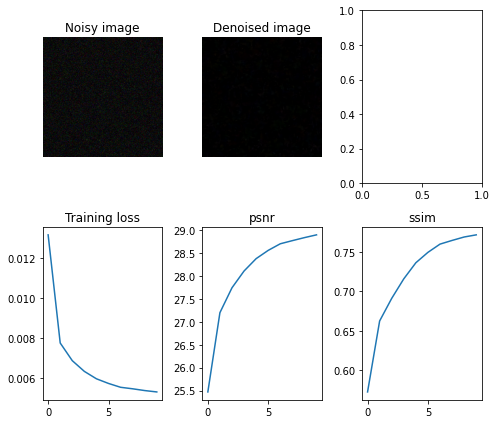

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp4.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

# Comparison with new model

In [ ]:
eval3 = exp3.evaluate()
eval4 = exp4.evaluate()

print("loss of DUDnCNN: {} \t\t\t loss of new model: {}\n".format(eval3["loss"],eval4["loss"]))
print("PSNR of DUDnCNN: {} \t\t\t PSNR of new model: {}\n".format(eval3["psnr"].cpu().numpy(), 
                                                             eval4["psnr"].cpu().numpy()))
print("SSIM of DUDnCNN: {} \t\t\t SSIM of new model: {}\n".format(eval3["ssim"],eval4["ssim"]))

loss of DUDnCNN: 0.0007575025275000371 			 loss of new model: 0.000811589345918037

PSNR of DUDnCNN: 38.07589340209961 			 PSNR of new model: 37.67527389526367

SSIM of DUDnCNN: 0.9279769062995911 			 SSIM of new model: 0.9065596461296082



# Change sigma value

In [18]:
train_set_20 = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(180,180), sigma=20)
test_set_20 = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(320,320), sigma=20)

train_set_25 = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(180,180), sigma=25)
test_set_25 = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(320,320), sigma=25)

train_set_30 = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(180,180), sigma=30)
test_set_30 = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(320,320), sigma=30)

train_set_35 = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(180,180), sigma=35)
test_set_35 = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(320,320), sigma=35)

train_set_40 = NoisyBSDSDataset(root_dir=dataset_root_dir, mode='train', image_size=(180,180), sigma=40)
test_set_40 = NoisyBSDSDataset(root_dir=test_dataset_root_dir, mode='test', image_size=(320,320), sigma=40)

DUDnCNN - sigma 20

In [19]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3_sigma20 = nt.Experiment(net, train_set_20, test_set_20, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3_sigma20", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 119.93s | Training Loss: 0.006666 | Evaluation Loss: 0.001249
Epoch 2 | Time: 120.02s | Training Loss: 0.004311 | Evaluation Loss: 0.001205
Epoch 3 | Time: 120.05s | Training Loss: 0.003990 | Evaluation Loss: 0.000941
Epoch 4 | Time: 120.15s | Training Loss: 0.003792 | Evaluation Loss: 0.000822
Epoch 5 | Time: 120.25s | Training Loss: 0.003670 | Evaluation Loss: 0.000729
Finish training for 5 epochs


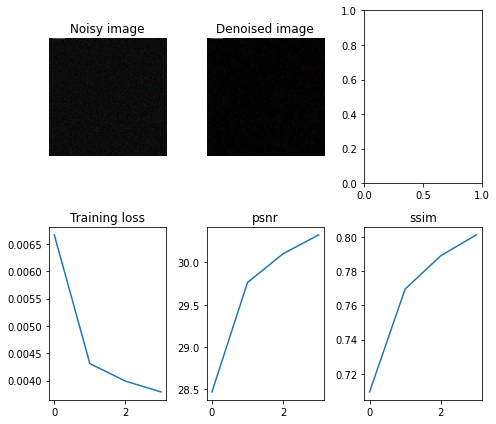

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3_sigma20.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

DUDnCNN - sigma 25

In [21]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3_sigma25 = nt.Experiment(net, train_set_25, test_set_25, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3_sigma25", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 120.25s | Training Loss: 0.008139 | Evaluation Loss: 0.001830
Epoch 2 | Time: 120.60s | Training Loss: 0.005526 | Evaluation Loss: 0.001656
Epoch 3 | Time: 120.93s | Training Loss: 0.005088 | Evaluation Loss: 0.001356
Epoch 4 | Time: 121.54s | Training Loss: 0.004868 | Evaluation Loss: 0.000941
Epoch 5 | Time: 121.60s | Training Loss: 0.004680 | Evaluation Loss: 0.000973
Finish training for 5 epochs


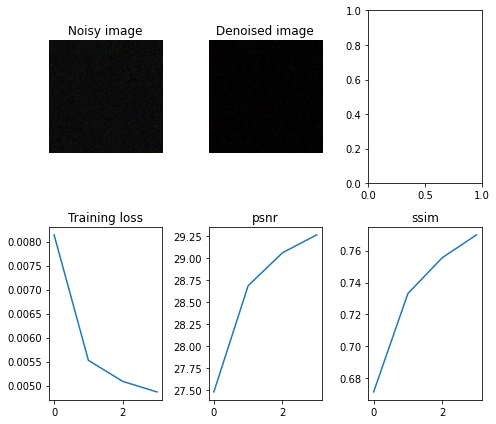

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3_sigma25.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

DUDnCNN - sigma 30

In [23]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3_sigma30 = nt.Experiment(net, train_set_30, test_set_30, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3_sigma30", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 120.63s | Training Loss: 0.009827 | Evaluation Loss: 0.005020
Epoch 2 | Time: 120.11s | Training Loss: 0.006842 | Evaluation Loss: 0.002814
Epoch 3 | Time: 120.85s | Training Loss: 0.006315 | Evaluation Loss: 0.002078
Epoch 4 | Time: 120.41s | Training Loss: 0.006014 | Evaluation Loss: 0.001090
Epoch 5 | Time: 120.53s | Training Loss: 0.005815 | Evaluation Loss: 0.002978
Finish training for 5 epochs


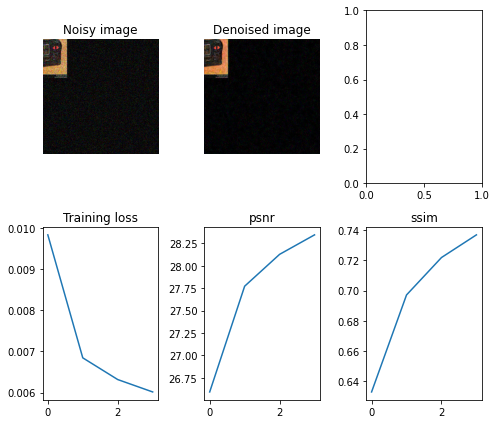

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3_sigma30.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

DUDnCNN - sigma 35

In [25]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3_sigma35 = nt.Experiment(net, train_set_35, test_set_35, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3_sigma35", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 120.71s | Training Loss: 0.011012 | Evaluation Loss: 0.002092
Epoch 2 | Time: 120.87s | Training Loss: 0.007830 | Evaluation Loss: 0.001556
Epoch 3 | Time: 121.00s | Training Loss: 0.007242 | Evaluation Loss: 0.001351
Epoch 4 | Time: 120.82s | Training Loss: 0.006956 | Evaluation Loss: 0.001470
Epoch 5 | Time: 121.08s | Training Loss: 0.006752 | Evaluation Loss: 0.001239
Finish training for 5 epochs


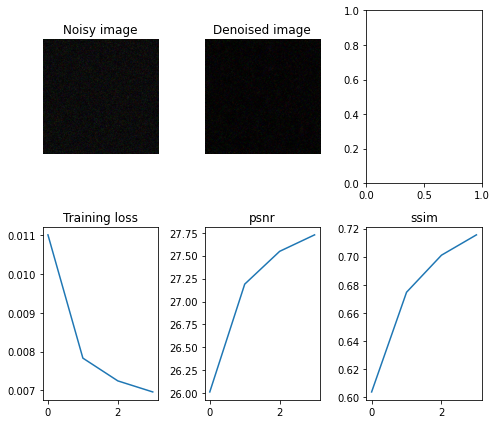

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3_sigma35.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

DUDnCNN - sigma 40

In [27]:
lr = 1e-3
net = DUDnCNN(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3_sigma40 = nt.Experiment(net, train_set_40, test_set_40, adam, stats_manager, batch_size=4,
                     output_dir="denoising_output_exp3_sigma40", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 | Time: 120.71s | Training Loss: 0.012712 | Evaluation Loss: 0.003244
Epoch 2 | Time: 120.61s | Training Loss: 0.008996 | Evaluation Loss: 0.001993
Epoch 3 | Time: 120.63s | Training Loss: 0.008372 | Evaluation Loss: 0.001324
Epoch 4 | Time: 120.53s | Training Loss: 0.008017 | Evaluation Loss: 0.001349
Epoch 5 | Time: 120.50s | Training Loss: 0.007830 | Evaluation Loss: 0.001234
Finish training for 5 epochs


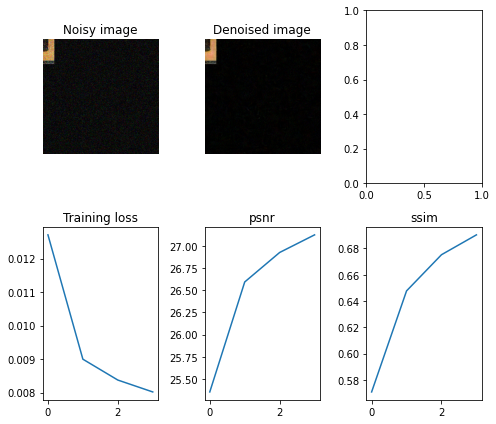

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
exp3_sigma40.run(num_epochs=5, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                               noisy=test_set[73][0]))

# Comparison between different sigma values

In [29]:
eval3_sigma20 = exp3_sigma20.evaluate()
eval3_sigma25 = exp3_sigma25.evaluate()
eval3_sigma30 = exp3_sigma30.evaluate()
eval3_sigma35 = exp3_sigma35.evaluate()
eval3_sigma40 = exp3_sigma40.evaluate()

print("sigma20")
print("loss of DUDnCNN: {} \t\t\t PSNR of DUDnCNN: {} \t\t\t SSIM of DUDnCNN: {} \n".format(eval3_sigma20["loss"],
                                                                                            eval3_sigma20["psnr"].cpu().numpy(),
                                                                                            eval3_sigma20["ssim"]))
print("sigma25")
print("loss of DUDnCNN: {} \t\t\t PSNR of DUDnCNN: {} \t\t\t SSIM of DUDnCNN: {} \n".format(eval3_sigma25["loss"],
                                                                                            eval3_sigma25["psnr"].cpu().numpy(),
                                                                                            eval3_sigma25["ssim"]))
print("sigma30")
print("loss of DUDnCNN: {} \t\t\t PSNR of DUDnCNN: {} \t\t\t SSIM of DUDnCNN: {} \n".format(eval3_sigma30["loss"],
                                                                                            eval3_sigma30["psnr"].cpu().numpy(),
                                                                                            eval3_sigma30["ssim"]))
print("sigma35")
print("loss of DUDnCNN: {} \t\t\t PSNR of DUDnCNN: {} \t\t\t SSIM of DUDnCNN: {} \n".format(eval3_sigma35["loss"],
                                                                                            eval3_sigma35["psnr"].cpu().numpy(),
                                                                                            eval3_sigma35["ssim"]))
print("sigma40")
print("loss of DUDnCNN: {} \t\t\t PSNR of DUDnCNN: {} \t\t\t SSIM of DUDnCNN: {} \n".format(eval3_sigma40["loss"],
                                                                                            eval3_sigma40["psnr"].cpu().numpy(),
                                                                                            eval3_sigma40["ssim"]))

sigma20
loss of DUDnCNN: 0.0007689436958171427 			 PSNR of DUDnCNN: 37.57421875 			 SSIM of DUDnCNN: 0.8761656284332275 

sigma25
loss of DUDnCNN: 0.0009461632699239999 			 PSNR of DUDnCNN: 36.614723205566406 			 SSIM of DUDnCNN: 0.8834127187728882 

sigma30
loss of DUDnCNN: 0.0029698758106678725 			 PSNR of DUDnCNN: 31.332429885864258 			 SSIM of DUDnCNN: 0.8579386472702026 

sigma35
loss of DUDnCNN: 0.0012918373171705753 			 PSNR of DUDnCNN: 35.207916259765625 			 SSIM of DUDnCNN: 0.807267963886261 

sigma40
loss of DUDnCNN: 0.0013058464017231017 			 PSNR of DUDnCNN: 35.280052185058594 			 SSIM of DUDnCNN: 0.8196060061454773 

